## Finding the Lyapunov Function using Counterexamples Method

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from scipy.linalg import solve_continuous_lyapunov
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from dreal import *

import timeit 

import tqdm
import copy

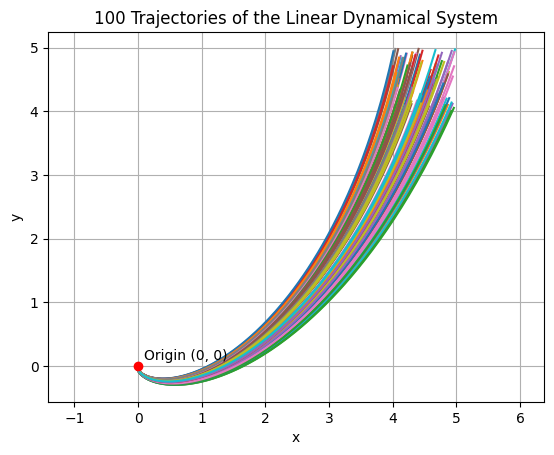

In [23]:
# System matrix
A = np.array([[-2, 1], [-1, -2]])

# Time
t = np.linspace(0, 10, 1000)

# Initial conditions
num_trajectories = 100
x0_values = np.random.uniform(low=4, high=5, size=(num_trajectories, 2))

X_data = np.zeros((len(t)*num_trajectories,2))
X_dot_data = np.zeros((len(t)*num_trajectories,2))

# Plotting trajectories
for i in range(num_trajectories):
    x = np.zeros((len(t), 2))
    x_dot = np.zeros((len(t), 2))
    x[0] = x0_values[i]
    for j in range(1, len(t)):
        x_dot[j-1] = np.dot(A, x[j-1])
        x[j] = x[j-1] + x_dot[j-1] * (t[j] - t[j-1])
    X_data[i*len(t):(i+1)*len(t),:] = x
    X_dot_data[i*len(t):(i+1)*len(t),:] = x_dot
    plt.plot(x[:, 0], x[:, 1])

# Plotting the origin
plt.plot(0, 0, 'ro')
plt.text(0.1, 0.1, 'Origin (0, 0)', fontsize=10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('100 Trajectories of the Linear Dynamical System')
plt.grid(True)
plt.axis('equal')
plt.show()

In [4]:
Q = np.eye(2)
# Defining the Lyapunov Function
P = solve_continuous_lyapunov(A.T, -Q)
P = torch.tensor(P, dtype=torch.float32)
A = torch.tensor(A, dtype=torch.float32)

## Neural Network

In [5]:
## NN for learning the Lyapunov Function
class Net(torch.nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        
    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        return out

In [6]:
# NN for learning dynamics
class fNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden1,  n_output):
        super().__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden1)
        self.layer2 = torch.nn.Linear(n_hidden1,n_output)  
        
    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = self.layer2(h_1) 
        return out

In [10]:
'''
For learning the Lyapunov Function and Dynamics Function together
'''
N = 500            # sample size
D_in = 2            # input dimension
H1 = 10              # hidden dimension
D_out = 1           # output dimension
torch.manual_seed(10)  
r = 3
# For the dynamics function
# Neural Network Structure
nn_h_f = 100
# Dimensions
nn_x = 2
# Weights for the LOSS
DECAY_MSE = 1
DECAY_LY = 1
DECAY_LYG = 1
# Epochs
n_epochs = 2
learning_rate = 0.0001
lr_warm = 0.005
# For Verification
beta = -0.02 # initial guess of beta
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.2
ball_ub = 1.2

# parameters for beta
Kf = 3.4599
KF = 5.452
d = 5e-4
loss = 0.0085 # equals alpha above


# DATA for training
X_train, X_test, y_train, y_test = train_test_split(X_data, X_dot_data, train_size=0.2, shuffle=False)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Batches Size
batch_size = 1000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

x_0 = torch.zeros([1, 2])
x_0 = x_0

'''
For verifying 
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2

In [8]:
# Defining the Helper Functions
def CheckLyapunov(x, f, V, ball_lb, ball_ub, config, epsilon):    
    # Given a dynamical system dx/dt = f(x,u) and candidate Lyapunov function V
    # Check the Lyapunov conditions within a domain around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub). 
    # If it return unsat, then there is no state violating the conditions. 
    
    ball= Expression(0)
    lie_derivative_of_V = Expression(0)
    
    for i in range(len(x)):
        ball += x[i]*x[i]
        lie_derivative_of_V += f[i]*V.Differentiate(x[i])  
    ball_in_bound = logical_and(ball_lb*ball_lb <= ball, ball <= ball_ub*ball_ub)
    
    # Constraint: x ∈ Ball → (V(c, x) > 0 ∧ Lie derivative of V <= 0)     
    condition = logical_and(logical_imply(ball_in_bound, V >= 0),
                           logical_imply(ball_in_bound, lie_derivative_of_V <= epsilon))
    return CheckSatisfiability(logical_not(condition),config)

def CheckdVdx(x, V, ball_ub, config, M):    
    # Given a candidate Lyapunov function V, check the Lipschitz constant within a domain around the origin (sqrt(∑xᵢ²) ≤ ball_ub). 
    # If it return unsat, then there is no state violating the conditions. 
    
    ball= Expression(0)
    derivative_of_V = Expression(0)
    
    for i in range(len(x)):
        ball += x[i]*x[i]
        derivative_of_V += V.Differentiate(x[i])*V.Differentiate(x[i])
    ball_in_bound = logical_and(ball <= ball_ub*ball_ub)
    
    # Constraint: x ∈ Ball → partial derivative of V <= M     
    condition = logical_imply(ball_in_bound, derivative_of_V <= M)
    return CheckSatisfiability(logical_not(condition),config)


def AddCounterexamples(x,CE,N): 
    # Adding CE back to sample set
    c = []
    nearby= []
    for i in range(CE.size()):
        c.append(CE[i].mid())
        lb = CE[i].lb()
        ub = CE[i].ub()
        nearby_ = np.random.uniform(lb,ub,N)
        nearby.append(nearby_)
    for i in range(N):
        n_pt = []
        for j in range(x.shape[1]):
            n_pt.append(nearby[j][i])             
        x = torch.cat((x, torch.tensor([n_pt])), 0)
    return x
  
def dtanh(s):
    # Derivative of activation
    return 1.0 - s**2

def Tune(x):
    # Circle function values
    y = []
    for r in range(0,len(x)):
        v = 0 
        for j in range(x.shape[1]):
            v += x[r][j]**2
        f = [torch.sqrt(v)]
        y.append(f)
    y = torch.tensor(y)
    return y

MSE: 0.12
RMSE: 0.34


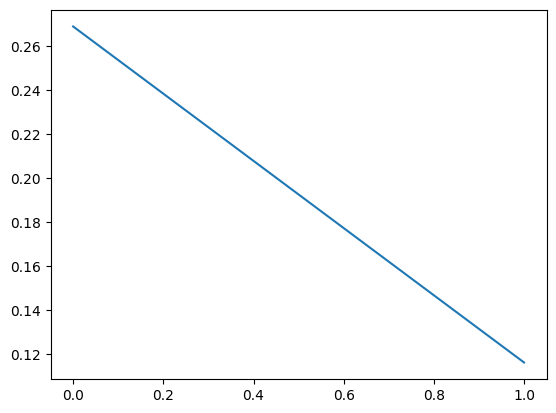

fNet(
  (layer1): Linear(in_features=2, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=2, bias=True)
)

In [13]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# Model
model_f = fNet(nn_x, nn_h_f, nn_x)
loss_fn = nn.MSELoss()  # mean square error
optimizer_f = torch.optim.Adam(model_f.parameters(), lr = lr_warm)

for epoch in range(n_epochs):
    model_f.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # Calculate the loss
            #loss = lossFunction(model_f, model_v, X_batch, y_batch);
            y_pred = model_f(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer_f.zero_grad()
            #optimizer_v.zero_grad()
            loss.backward() 
            optimizer_f.step()
            #optimizer_v.step()
            bar.set_postfix(mse=float(loss))
    #evaluate accuracy at end of each epoch
    model_f.eval()
    #model_v.eval()
    y_pred = model_f(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if loss < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model_f.state_dict())
    with torch.no_grad():
        torch.cuda.empty_cache()
# restore model and return best accuracy
model_f.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()
model_f.eval()

## Taking Batches

In [12]:
out_iters = 0
valid = False
while out_iters < 2 and not valid: 
    start = timeit.default_timer()
    model_v = Net(D_in,H1, D_out)
    L = []
    i = 0 
    t = 0
    max_iters = 5000 # increase number of epoches if cannot find a valid LF
    optimizer_v = torch.optim.Adam(model_v.parameters(), lr=learning_rate)

    while i < max_iters and not valid: 
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {i}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # Calculate the loss                        
                x = X_batch.float()
                x = x
                # Value of Lyapunov Model
                V_candidate = model_v(x)
                X0 = model_v(x_0)
                # Value of Function Model
                f = model_f(x)
                Circle_Tuning = Tune(x)
                Circle_Tuning = Circle_Tuning
                # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
                L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model_v.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model_v.layer1.weight.t())+model_v.layer1.bias)),model_v.layer1.weight),f.t()),0)
        
                dVdx = torch.mm(torch.mm(dtanh(V_candidate),model_v.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model_v.layer1.weight.t())+model_v.layer1.bias)),model_v.layer1.weight)
                
                # MSE Loss
                L1 = loss_fn(f,y_batch)/X_batch.shape[0]
                
                # With tuning
                Lyapunov_risk = (F.relu(-V_candidate)+ 1.2*F.relu(L_V+0.2)).mean()\
                    +((Circle_Tuning-V_candidate).pow(2)).mean()+ 1.2*(X0).pow(2) + 0.01*torch.norm(dVdx) + L1
 
                L.append(Lyapunov_risk.item())
                optimizer_v.zero_grad()
                optimizer_f.zero_grad()
                Lyapunov_risk.backward()
                optimizer_v.step() 
                optimizer_f.step() 

            print(i, "Lyapunov Risk=",Lyapunov_risk.item())
            # Finding the values for the new model function
            f_w1 = model_f.layer1.weight.data.cpu().numpy()
            f_w2 = model_f.layer2.weight.data.cpu().numpy()
            f_b1 = model_f.layer1.bias.data.cpu().numpy()
            f_b2 = model_f.layer2.bias.data.cpu().numpy()

            f_h1 = []
            f_z1 = np.dot(vars_,f_w1.T)+f_b1
            for n in range(len(f_z1)):
                f_h1.append(tanh(f_z1[n]))
            f_learn = np.dot(f_h1,f_w2.T)+f_b2
            # save the weights and biases 
            w1 = model_v.layer1.weight.data.cpu().numpy()
            w2 = model_v.layer2.weight.data.cpu().numpy()
            b1 = model_v.layer1.bias.data.cpu().numpy()
            b2 = model_v.layer2.bias.data.cpu().numpy()
        
            # Falsification with SMT solver
            if i % 10 == 0:
                    
                # Candidate V
                z1 = np.dot(vars_,w1.T)+b1
        
                a1 = []
                for j in range(0,len(z1)):
                    a1.append(tanh(z1[j]))
                z2 = np.dot(a1,w2.T)+b2
                V_learn = tanh(z2.item(0))
        
                print('===========Verifying==========')        
                start_ = timeit.default_timer() 
                beta = -np.maximum(beta, -0.02) # in case beta is too negative and cannot return any results
                result= CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta) # SMT solver
                stop_ = timeit.default_timer() 
        
                if (result): 
                    print("Not a Lyapunov function. Found counterexample: ")
                    print(result)
                    x = x.to('cpu')
                    x = AddCounterexamples(x,result,10)
                else:  
                    # calculate norm of dVdx with the SMT solver
                    M = 0.05 # lower bound of M
                    dvdx_bound = np.sqrt(M)
                    violation = CheckdVdx(vars_, V_learn, ball_ub, config, M) 
                    while violation:
                        violation = CheckdVdx(vars_, V_learn, ball_ub, config, M)
                        if not violation:
                            dvdx_bound = np.sqrt(M)
                            print(dvdx_bound, "is the norm of dVdx")
                        M += 0.001
                    beta = -dvdx_bound*((Kf+KF)*d+loss) # update beta 
                    result_strict= CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta) # SMT solver
                    if not result_strict:
                        valid = True
                        print("Satisfy conditions with beta = ", beta)
                        print(V_learn, " is a Lyapunov function.")
                t += (stop_ - start_)
                print('==============================') 
        i += 1

    stop = timeit.default_timer()
    print(f"Epoch{i} and Valid {valid}")

    np.savetxt("w1_vdp.txt", model_v.layer1.weight.data.cpu(), fmt="%s")
    np.savetxt("w2_vdp.txt", model_v.layer2.weight.data.cpu(), fmt="%s")
    np.savetxt("b1_vdp.txt", model_v.layer1.bias.data.cpu(), fmt="%s")
    np.savetxt("b2_vdp.txt", model_v.layer2.bias.data.cpu(), fmt="%s")

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0 Lyapunov Risk= 1.1134709119796753
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.63510408641494986, -0.62510408641494986]
x2 : [0.54709119491257974, 0.55709119491257975]
1 Lyapunov Risk= 1.002280592918396
2 Lyapunov Risk= 0.9012830257415771
3 Lyapunov Risk= 0.8893147110939026
4 Lyapunov Risk= 0.878730833530426
5 Lyapunov Risk= 0.8702576756477356


KeyboardInterrupt: 

## Taking Train Dataset Whole

In [14]:
out_iters = 0
valid = False
while out_iters < 2 and not valid: 
    start = timeit.default_timer()
    model_v = Net(D_in,H1, D_out)
    L = []
    i = 0 
    t = 0
    max_iters = 5000 # increase number of epoches if cannot find a valid LF
    optimizer_v = torch.optim.Adam(model_v.parameters(), lr=learning_rate)

    while i < max_iters and not valid: 
        # Calculate the loss
        X_train = X_train
        y_train = y_train
        x = X_train.float()
        x = x
        # Value of Lyapunov Model
        V_candidate = model_v(x)
        X0 = model_v(x_0)
        # Value of Function Model
        f = model_f(x)
        Circle_Tuning = Tune(x)
        Circle_Tuning = Circle_Tuning
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model_v.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model_v.layer1.weight.t())+model_v.layer1.bias)),model_v.layer1.weight),f.t()),0)
        
        dVdx = torch.mm(torch.mm(dtanh(V_candidate),model_v.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model_v.layer1.weight.t())+model_v.layer1.bias)),model_v.layer1.weight)
                
        # MSE Loss
        L1 = loss_fn(model_f(X_train),y_train)
                
        # Needs to be tuned
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.2*F.relu(L_V+0.2)).mean() +((Circle_Tuning-V_candidate).pow(2)).mean()+ 1.2*(X0).pow(2) + 0.01*torch.norm(dVdx) + 10 * L1
 
        L.append(Lyapunov_risk.item())
        optimizer_v.zero_grad()
        optimizer_f.zero_grad()
        Lyapunov_risk.backward()
        optimizer_v.step() 
        optimizer_f.step() 

        print(f"{i}) Lyapunov Risk = {Lyapunov_risk.item()}, MSE = {L1}, V_loss = {F.relu(-V_candidate).mean()}, Lv_loss = {F.relu(L_V).mean()}, Circular Tuning Loss = {((Circle_Tuning-V_candidate).pow(2)).mean()}")
        # Finding the values for the new model function
        f_w1 = model_f.layer1.weight.data.cpu().numpy()
        f_w2 = model_f.layer2.weight.data.cpu().numpy()
        f_b1 = model_f.layer1.bias.data.cpu().numpy()
        f_b2 = model_f.layer2.bias.data.cpu().numpy()

        f_h1 = []
        f_z1 = np.dot(vars_,f_w1.T)+f_b1
        for n in range(len(f_z1)):
            f_h1.append(tanh(f_z1[n]))
        f_learn = np.dot(f_h1,f_w2.T)+f_b2
        # save the weights and biases 
        w1 = model_v.layer1.weight.data.cpu().numpy()
        w2 = model_v.layer2.weight.data.cpu().numpy()
        b1 = model_v.layer1.bias.data.cpu().numpy()
        b2 = model_v.layer2.bias.data.cpu().numpy()
        
        # Falsification with SMT solver
        if i % 10 == 0:
                    
            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1
        
            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))
        
            print('===========Verifying==========')        
            start_ = timeit.default_timer() 
            beta = -np.maximum(beta, -0.02) # in case beta is too negative and cannot return any results
            result= CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta) # SMT solver
            stop_ = timeit.default_timer() 
        
            if (result): 
                    print("Not a Lyapunov function. Found counterexample: ")
                    print(result)
                    x = x.to('cpu')
                    x = AddCounterexamples(x,result,10)
            else:  
                    # calculate norm of dVdx with the SMT solver
                    M = 0.05 # lower bound of M
                    dvdx_bound = np.sqrt(M)
                    violation = CheckdVdx(vars_, V_learn, ball_ub, config, M) 
                    while violation:
                        violation = CheckdVdx(vars_, V_learn, ball_ub, config, M)
                        print("Not a Lyapunov function yet, checking Violations for dVdx.")
                        if not violation:
                            dvdx_bound = np.sqrt(M)
                            print(dvdx_bound, "is the norm of dVdx")
                        M += 0.001
                    beta = -dvdx_bound*((Kf+KF)*d+loss) # update beta 
                    result_strict= CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta) # SMT solver
                    beta = beta.detach().numpy()
                    if not result_strict:
                        valid = True
                        print("Satisfy conditions with beta = ", beta)
                        print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================') 
        i += 1

    stop = timeit.default_timer()
    
    np.savetxt("w1_vdp.txt", model_v.layer1.weight.data.cpu(), fmt="%s")
    np.savetxt("w2_vdp.txt", model_v.layer2.weight.data.cpu(), fmt="%s")
    np.savetxt("b1_vdp.txt", model_v.layer1.bias.data.cpu(), fmt="%s")
    np.savetxt("b2_vdp.txt", model_v.layer2.bias.data.cpu(), fmt="%s")

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

4) Lyapunov Risk = 1.9064997434616089, MSE = 0.06863455474376678, V_loss = 0.0, Lv_loss = 0.0023770127445459366, Circular Tuning Loss = 0.8787225484848022
5) Lyapunov Risk = 1.8343505859375, MSE = 0.061628516763448715, V_loss = 0.0, Lv_loss = 0.002303397050127387, Circular Tuning Loss = 0.8784118890762329
6) Lyapunov Risk = 1.779808759689331, MSE = 0.056323595345020294, V_loss = 0.0, Lv_loss = 0.0022295601665973663, Circular Tuning Loss = 0.8780961036682129
7) Lyapunov Risk = 1.7213053703308105, MSE = 0.050517819821834564, V_loss = 0.0, Lv_loss = 0.0021443285513669252, Circular Tuning Loss = 0.8777714967727661
8) Lyapunov Risk = 1.6600310802459717, MSE = 0.04436909407377243, V_loss = 0.0, Lv_loss = 0.0020459219813346863, Circular Tuning Loss = 0.8774458765983582
9) Lyapunov Risk = 1.6033902168273926, MSE = 0.03870458900928497, V_loss = 0.0, Lv_loss = 0.0022168392315506935, Circular Tuning Loss = 0.8771297931671143
10) Lyapunov Risk = 1.5470212697982788, MSE = 0.03316282853484154, V_los

KeyboardInterrupt: 

In [15]:
# Checking Result with Bounded Beta
beta = -0.02
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f_learn, V_learn, ball_lb, ball_ub, config, beta)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
    print(result)
else:  
    print("Satisfy conditions with beta = ",beta)
    print(V_learn, " is a Lyapunov function.")
t += (stop_ - start_)

Not a Lyapunov function. Found counterexample: 
x1 : [-0.62005204320747498, -0.61005204320747497]
x2 : [0.53085321859162149, 0.5408532185916215]


In [17]:
beta = 0
f = [-2*x1 + x2,
        -x1 - 2*x2]
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config, beta)
stop_ = timeit.default_timer() 
if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
    print(result)
else:  
    print("Satisfy conditions with beta= ", beta)
    print(V_learn, " is a Lyapunov function for actual dynamics.")
t += (stop_ - start_)


Not a Lyapunov function. Found counterexample: 
x1 : [-0.61252602160373748, -0.60252602160373747]
x2 : [0.52273423043114231, 0.53273423043114232]


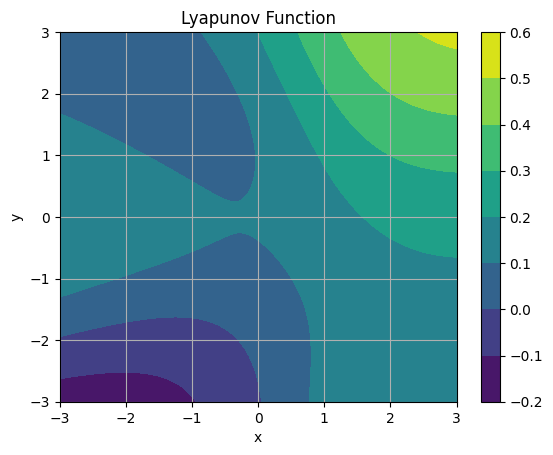

In [18]:
# Plotting the Lyapunov Function
fig, ax = plt.subplots()
# Define grid for plotting
len_sample = [256, 256]
x = np.linspace(-3, 3, len_sample[0])
y = np.linspace(-3, 3, len_sample[1])
X, Y = np.meshgrid(x, y)

# Convert X and Y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Concatenate X and Y to create input data tensor
input_data = torch.stack((X_tensor, Y_tensor), dim=-1).reshape(-1, 2)
unflatten = torch.nn.Unflatten(0, len_sample)

# Lyapunov Function
with torch.no_grad():
    V = model_v(input_data)
    cont_out = unflatten(V)
    cont_out = cont_out.detach().numpy()
# Plot the vector field
cp = ax.contourf(X, Y, cont_out[:,:,0])
fig.colorbar(cp)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lyapunov Function')
plt.show()

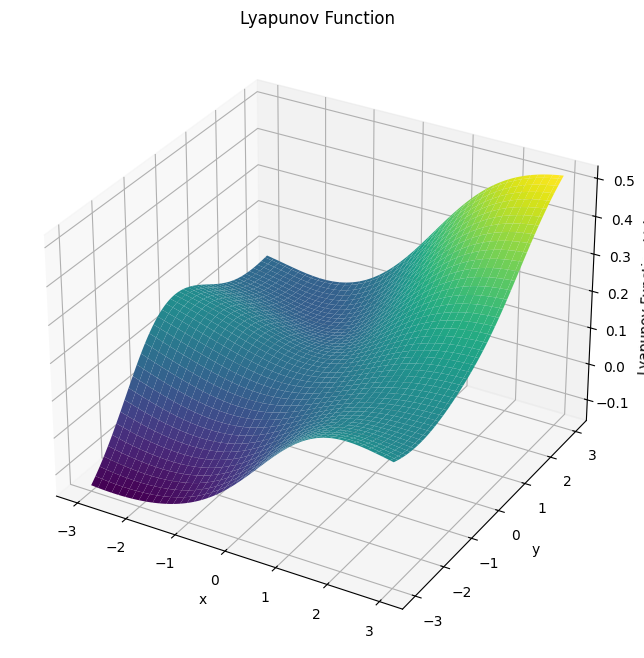

In [19]:
# Plot the Lyapunov function in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, cont_out[:,:,0], cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Lyapunov Function Value')
ax.set_title('Lyapunov Function')
plt.show()

## Ideal Plots for the Lyapunov Function and the Vector Field

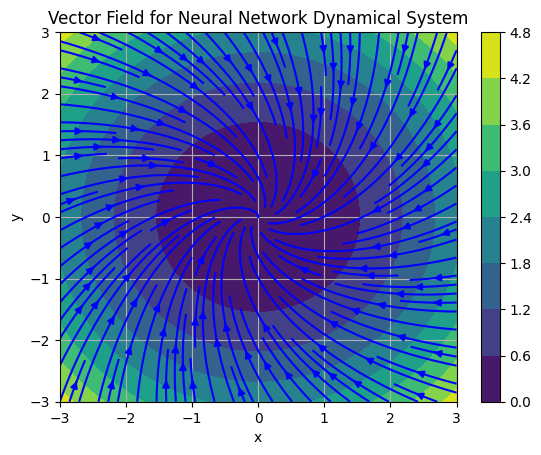

In [20]:
fig, ax = plt.subplots()
# Define grid for plotting
len_sample = [256, 256]
x = np.linspace(-3, 3, len_sample[0])
y = np.linspace(-3, 3, len_sample[1])
X, Y = np.meshgrid(x, y)

# Convert X and Y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Concatenate X and Y to create input data tensor
input_data = torch.stack((X_tensor, Y_tensor), dim=-1).reshape(-1, 2)
unflatten = torch.nn.Unflatten(0, len_sample)

# Vector Field
with torch.no_grad():
    F = torch.empty(len(input_data),2, dtype=torch.float32)
    for i in range(len(input_data)):
        x = input_data[i,:].unsqueeze(1)
        F[i,:] = torch.reshape(torch.matmul(A,x)[:],(1,-1))
    vect_out = unflatten(F)
    vect_out = vect_out.detach().numpy()
    U = vect_out[:,:, 0]
    V = vect_out[:,:,1]
ax.streamplot(X, Y, U, V, density=1.4, linewidth=None, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field for Neural Network Dynamical System')

# Lyapunov Function
V = torch.empty(len(input_data),1, dtype=torch.float32)
for i in range(len(input_data)):
    x = input_data[i,:]
    x_T = input_data[i,:].unsqueeze(1) 
    V[i] = torch.matmul(torch.matmul(x, P), x_T)
cont_out = unflatten(V)
cont_out = cont_out.detach().numpy()

# Plot the vector field
cp = ax.contourf(X, Y, cont_out[:,:,0])
fig.colorbar(cp)
plt.grid(True)
plt.show()

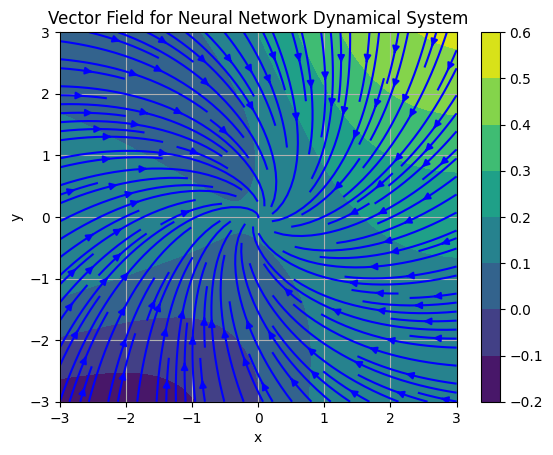

In [21]:
fig, ax = plt.subplots()
# Define grid for plotting
len_sample = [256, 256]
x = np.linspace(-3, 3, len_sample[0])
y = np.linspace(-3, 3, len_sample[1])
X, Y = np.meshgrid(x, y)

# Convert X and Y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Concatenate X and Y to create input data tensor
input_data = torch.stack((X_tensor, Y_tensor), dim=-1).reshape(-1, 2)
unflatten = torch.nn.Unflatten(0, len_sample)

# Vector Field
with torch.no_grad():
    F = model_f(input_data)
    vect_out = unflatten(F)
    vect_out = vect_out.detach().numpy()
    U = vect_out[:,:, 0]
    V = vect_out[:,:,1]
ax.streamplot(X, Y, U, V, density=1.4, linewidth=None, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field for Neural Network Dynamical System')

# Lyapunov Function
with torch.no_grad():
    V = model_v(input_data)
    cont_out = unflatten(V)
    cont_out = cont_out.detach().numpy()
# Plot the vector field
cp = ax.contourf(X, Y, cont_out[:,:,0])
fig.colorbar(cp)
plt.grid(True)
plt.show()

## Plot the Training Trajectories and the Output Trajectory taken by the model

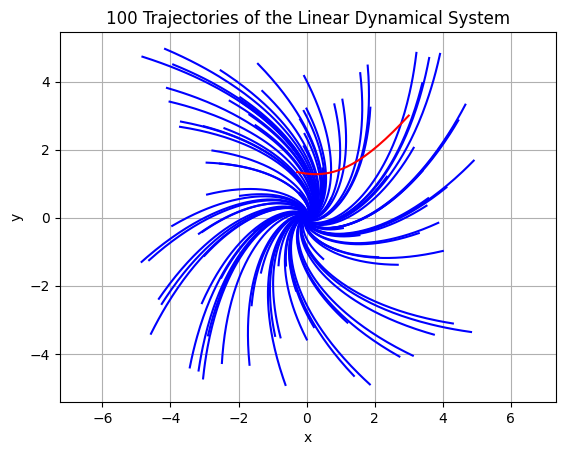

In [116]:
# Plotting trajectories
t = np.linspace(0, 10, 1000)

for i in range(num_trajectories):
    x = np.zeros((len(t), 2))
    x_dot = np.zeros((len(t), 2))
    x[0] = x0_values[i]
    for j in range(1, len(t)):
        x_dot[j-1] = np.dot(A, x[j-1])
        x[j] = x[j-1] + x_dot[j-1] * (t[j] - t[j-1])
    X_data[i*len(t):(i+1)*len(t),:] = x
    X_dot_data[i*len(t):(i+1)*len(t),:] = x_dot
    plt.plot(x[:, 0], x[:, 1],'b')

# Plotting the final trajectory
x = torch.zeros((len(t), 2))
x[0] = torch.tensor([3,3], dtype=torch.float32)
for j in range(1, len(t)):
    x[j] = x[j-1] + model_f(x[j-1]) * (t[j] - t[j-1])
x = x.detach().numpy()
plt.plot(x[:, 0], x[:, 1],'r')

# Plotting the origin
#plt.plot(0, 0, 'ro')
#plt.text(0.1, 0.1, 'Origin (0, 0)', fontsize=10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('100 Trajectories of the Linear Dynamical System')
plt.grid(True)
plt.axis('equal')
plt.show()